<h1 style="text-align:center;">
Segmentación De Alojamientos Y Predicción De Precio
</h1>

**Elaboró:** *Alejandro Hernández Rodríguez*

## Objetivo

Realizar un análisis completo del conjunto de datos de **Airbnb** para identificar y describir diferentes segmentos de oferta (por zona, tipo, precio) y posteriormente construir un modelo predictivo.



---



## Datos

Se trabajó con el conjunto de datos disponibles en **Kagle** bajo el nombre de ***Airbnb Open Data***, accesible en el siguiente enlace: [https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata/data](https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata/data)



---



## 1. Preparación Del Entorno Y Carga De Datos

A continuación, se importarán las librerías necesarias de Python y se cargará el conjunto de datos, qué será utilizado en las etapas de análisis, visualización y modelado.

In [1]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Configuraciones
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Para el modelo predictivo
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Carga del dataset
data = pd.read_csv('airbnb_open_data.csv', low_memory=False)

# Información inicial
print(f'Dimensiones del dataset: {data.shape}')
print('\nPrimeras 5 filas:')
data.head()

Dimensiones del dataset: (102599, 26)

Primeras 5 filas:


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,country code,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,US,False,strict,Private room,2020.0,$966,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,US,False,moderate,Entire home/apt,2007.0,$142,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,US,True,flexible,Private room,2005.0,$620,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,US,True,moderate,Entire home/apt,2005.0,$368,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,US,False,moderate,Entire home/apt,2009.0,$204,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN




---



## 2. Exploración Inicial Y Comprensión De Los Datos

In [2]:
# Información general del dataset

# 1. Normalizar nombres de columnas: minúsculas y reemplazar espacios por guiones bajos
data.columns = data.columns.str.lower().str.replace(' ', '_')

# 2. Información general de las columnas, tipos de datos y nulos
print('------ INFORMACIÓN GENERAL ------\n')
print(data.info())

# 3. Estadísticas descriptivas de las columnas numéricas
print('\n------ ESTADÍSTICAS DESCRIPTIVAS ------\n')
print(data.describe())

# 4. Cantidad de valores únicos por columna
print('\n------ VALORES ÚNICOS POR COLUMNA ------\n')
print(data.nunique())

# 5. Detección de registros duplicados
print('\n------ VALORES DUPLICADOS ------')
print(data.duplicated().sum())

------ INFORMACIÓN GENERAL ------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   name                            102349 non-null  object 
 2   host_id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host_name                       102193 non-null  object 
 5   neighbourhood_group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country_code                    102468 non-null  object 
 11  instant_bookable                102494 non-

### Resumen Ee hallazgos De La Exploración y Comprensión Inicial

En la revisión del dataset se identificaron las siguientes observaciones relevantes:

- Existen columnas con alta cantidad de valores nulos como `house_rules` y `license`, lo que limita su utilidad en el análisis.  
- Algunas columnas como `country` y `country_code` presentan un único valor, por lo que no aportan variabilidad a los resultados.  
- Se detectaron inconsistencias en los datos numéricos, por ejemplo:  
  - `minimum_nights` con valores negativos y muy superiores a lo esperado.  
  - `availability_365` con valores fuera del rango válido (mayores a 365).  
- Las columnas `price` y `service_fee` están definidas como texto y contienen el símbolo `"$"`, lo que requiere una transformación a formato numérico para su análisis correcto.  
- La columna `last_review` se encuentra en un formato de texto y debe transformarse a tipo **fecha (`datetime`)** para facilitar su análisis temporal.  
- Se identificó falta de uniformidad en valores categóricos, con diferencias en escritura que podrían generar sesgos en el análisis.  
- Variables como `id` y `host_id` presentan duplicados o gran variabilidad que deben revisarse para evitar problemas de calidad en los resultados.  

En conclusión, el dataset requiere un proceso de limpieza y estandarización antes de su uso en análisis avanzados, con especial atención en:  

- Imputación de valores faltantes  
- Corrección de outliers  
- Transformación de formatos (numéricos y fechas)  
- Normalización de categorías  



---



## 3. Limpieza De Datos

### Eliminación De Columnas Innecesarias

Se eliminaron las columnas `country` y `country_code` porque el dataset corresponde únicamente a Estados Unidos, por lo que estas variables no aportan variabilidad ni información relevante para el análisis ni para el modelado predictivo.

In [3]:
# 1. Crear una copia del dataset para trabajar
df = data.copy()

# 2. Columnas que no aportan valor para el análisis o modelado
df = df.drop(columns=['country', 'country_code'])

### Detección y Eliminación De Duplicados

Antes de abordar la detección y el tratamiento de valores faltantes, es fundamental garantizar la **integridad del conjunto de datos**.  
Los registros duplicados pueden distorsionar el análisis y generar sesgos en los resultados.  

Por ello, el **primer paso** en cualquier proceso de limpieza debe ser **identificar y eliminar registros redundantes**, asegurando que cada observación represente información única y válida.


In [4]:
# Eliminación de valores duplicados

# 1. Verificar cantidad de registros antes de eliminar duplicados
print(f'Dimensiones del dataset antes de eliminar duplicados: {df.shape}')

# 2. Eliminar registros duplicados basados en la columna 'id'
df.drop_duplicates(subset=['id'], inplace=True)

# 3. Verificar cantidad de registros después de eliminar duplicados
print(f'Dimensiones del dataset después de eliminar duplicados: {df.shape}')

Dimensiones del dataset antes de eliminar duplicados: (102599, 24)
Dimensiones del dataset después de eliminar duplicados: (102058, 24)




---



### Transformación De Formatos

Como se había mencionado en el ***Resumen de Hallazgos de la Exploración y Comprensión Inicial***, se identificaron tres problemas principales en el conjunto de datos:

1. **Columnas numéricas con formato incorrecto**: Variables como `price` y `service_feed` estaban definidas como texto, conteniendo símbolos como `"$"` y `","`, lo que impedía su correcto análisis numérico.  
2. **Valores categóricos inconsistentes**: En la columna `neighbourhood_group` se detectaron errores de escritura (ej. *brookln* en lugar de *Brooklyn*, *manhatan* en lugar de *Manhattan*) que podían distorsionar los resultados.  
3. **Columnas de fecha en formato inadecuado**: La variable `last_review` estaba almacenada como texto y requería ser transformada a tipo `datetime` para facilitar su análisis temporal.  

Para dar solución a estos problemas se aplicaron las siguientes transformaciones:  

- Conversión de la columna `last_review` a tipo `datetime`.  
- Eliminación de los símbolos `"$"` y `","` en las columnas `price` y `service_feed`, seguidos de su conversión a tipo `float`.  
- Corrección de errores ortográficos en la columna `neighbourhood_group` y estandarización de valores categóricos.  

Estas transformaciones garantizan que el dataset cuente con **valores consistentes, tipos de datos correctos y categorías homogéneas**, permitiendo avanzar con mayor confiabilidad hacia la etapa de modelado.


In [5]:
# 1. Convertir la columna last_review a tipo datetime
df['last_review'] = pd.to_datetime(df['last_review'])

# 2. Remplazar o eliminar los símbolos "$" y "," en la
# columnas price
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')

# 3. Convertir la columna price a tipo float
df['price'] = df['price'].astype(float)

# 4. Remplazar o eliminar los símbolos "$" y "," en la
# columnas service_fee
df['service_fee'] = df['service_fee'].str.replace('$', '')
df['service_fee'] = df['service_fee'].str.replace(',', '')

# 5. Convertir la columna price a tipo float
df['service_fee'] = df['service_fee'].astype(float)

# 6. Corregir errores ortográficos en neighbourhood_group
df['neighbourhood_group'] = df['neighbourhood_group'].replace({
    'brookln': 'Brooklyn',
    'manhatan': 'Manhattan'
}).str.strip()



---



### Detección De Datos Faltantes

In [6]:
# Análisis de valores faltantes basado en la exploración inicial
print('------ ANÁLISIS DE VALORES FALTANTES ------\n')

# 1. Crear un DataFrame con el conteo de valores nulos y su porcentaje respecto al total de registros
missing_analysis = pd.DataFrame({
    'Valores Faltantes': df.isna().sum(),
    'Porcentaje': df.isna().mean() * 100
}).sort_values('Porcentaje', ascending=False)

# 2. Mostrar el análisis de valores faltantes
print(missing_analysis)

------ ANÁLISIS DE VALORES FALTANTES ------

                                Valores Faltantes  Porcentaje
license                                    102056   99.998040
house_rules                                 51842   50.796606
last_review                                 15832   15.512748
reviews_per_month                           15818   15.499030
availability_365                              448    0.438966
host_name                                     404    0.395853
minimum_nights                                400    0.391934
review_rate_number                            319    0.312567
calculated_host_listings_count                319    0.312567
host_identity_verified                        289    0.283172
service_fee                                   273    0.267495
name                                          250    0.244959
price                                         247    0.242019
construction_year                             214    0.209685
number_of_reviews        

El análisis revela que las columnas ```license``` (≈100%) y ```house_rules``` (≈51%) presentan un nivel excesivo de valores nulos, lo que limita su utilidad para el análisis.

Variables como ```last_review``` y ```reviews_per_month``` muestran alrededor del 15% de datos faltantes.  

El resto de las columnas tiene porcentajes de valores nulos menores al 1%, lo que facilita su tratamiento mediante imputación o eliminación puntual de registros.



---



### Tratamiento De Datos Faltantes

Se decidió eliminar aquellas columnas del conjunto de datos que presentan **más del 50% de valores ausentes**, ya que estas variables aportan poca información útil tanto para el análisis exploratorio de datos como para la construcción del modelo predictivo.

El criterio aplicado fue el siguiente:  
- Se calculó la proporción de valores faltantes por columna y se identificaron aquellas cuyo porcentaje superaba el 50%.  
- Todas estas columnas fueron eliminadas automáticamente del DataFrame para asegurar que los análisis y modelos posteriores se basen en datos con suficiente cobertura.


In [7]:
# 1. Mostrar el total de columnas antes de la eliminación
print(f'Total de columnas antes de la eliminación: {df.shape[1]}\n')

# 2. Mostrar columnas con más del 50% de valores faltantes
print('Columnas con más del 50% de valores faltantes:')
print(f'{df.columns[df.isna().mean() > 0.5]}\n')

# 3. Eliminar columnas con más del 50% de valores faltantes
df = df.drop(df.columns[df.isnull().mean() > 0.5], axis=1)

# 4. Mostrar total de columnas después de la eliminación
print(f'Total de columnas después de la eliminación: {df.shape[1]}')

Total de columnas antes de la eliminación: 24

Columnas con más del 50% de valores faltantes:
Index(['house_rules', 'license'], dtype='object')

Total de columnas después de la eliminación: 22


De forma complementaria, se eliminaron filas con valores nulos en columnas críticas, como `price`, `name`, `host_identity_verified`, `neighbourhood_group`, `neighbourhood`, `cancellation_policy`, `availability_365`, `instant_bookable`, `host_name`, `construction_year`, `lat`, `long` y `minimum_nights`, con el objetivo de asegurar que los registros utilizados en el análisis sean completos y confiables, evitando sesgos en los resultados.  

Adicionalmente, se imputaron valores faltantes en columnas menos críticas para mantener la integridad del dataset:  

- `service_fee` se completó con 0.  
- Columnas numéricas como `reviews_per_month`, `minimum_nights`, `availability_365`, `calculated_host_listings_count` se rellenaron con la **media**, mientras que `number_of_reviews` y `review_rate_number` se rellenaron con la **mediana**, según corresponda.  
- Para `last_review`, se imputaron usando relleno hacia adelante (`ffill`) para mantener consistencia temporal.  

Este enfoque asegura un dataset **completo, consistente y listo para análisis y modelado predictivo**, preservando la información relevante sobre valores ausentes.



In [8]:
# 1. Eliminar filas con datos faltantes en columnas críticas
critical_cols = [
    'price', 'name', 'host_identity_verified',
    'neighbourhood_group','neighbourhood',
    'cancellation_policy', 'availability_365',
    'instant_bookable','host_name','construction_year',
    'lat','long', 'minimum_nights'
]
df = df.dropna(subset=critical_cols)

# 2. service_fee: rellenar nulos con 0
df['service_fee'] = df['service_fee'].fillna(0)

# 3. Rellenar nulos en 'reviews_per_month' usando la media
# (para mantener consistencia en la frecuencia promedio de reseñas)
df['reviews_per_month'].fillna(df['reviews_per_month'].mean(), inplace=True)

# 4. Rellenar nulos en 'minimum_nights' usando la media
# (para asegurar que el número mínimo de noches sea representativo)
df['minimum_nights'].fillna(df['minimum_nights'].mean(), inplace=True)

# 5. Rellenar nulos en 'availability_365' usando la media
# (para conservar la disponibilidad promedio de los alojamientos)
df['availability_365'].fillna(df['availability_365'].mean(), inplace=True)

# 6. Rellenar nulos en 'calculated_host_listings_count' usando la media
# (para mantener la cantidad promedio de anuncios por anfitrión)
df['calculated_host_listings_count'].fillna(df['calculated_host_listings_count'].mean(), inplace=True)

# 7. Rellenar nulos en 'number_of_reviews' usando la mediana
# (para evitar que valores extremos afecten la imputación)
df['number_of_reviews'].fillna(df['number_of_reviews'].median(), inplace=True)

# 8. Rellenar nulos en 'review_rate_number' usando la mediana
# (para mantener una tasa de reseñas representativa sin sesgo por outliers)
df['review_rate_number'].fillna(df['review_rate_number'].median(), inplace=True)

# 9. Imputar fechas faltantes con ffill en 'last_review'
df['last_review'] = df['last_review'].ffill()

Antes de avanzar, se verifica que no existan valores faltantes después del tratamiento aplicado.

In [9]:
# Verificar valor nulos
print(df.isna().sum())

id                                0
name                              0
host_id                           0
host_identity_verified            0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
lat                               0
long                              0
instant_bookable                  0
cancellation_policy               0
room_type                         0
construction_year                 0
price                             0
service_fee                       0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
review_rate_number                0
calculated_host_listings_count    0
availability_365                  0
dtype: int64




---



### Identificación De Outliers

Con base en la limpieza y transformación previa de los datos, el siguiente paso consiste en **identificar valores atípicos (outliers)** en las columnas numéricas del dataset.  

El objetivo de esta etapa es:  

1. **Detectar valores extremos** que se alejan significativamente de la distribución general de la columna.  
2. **Preparar la información** para decidir si estos valores deben mantenerse o tratarse de manera especial antes de cualquier análisis o modelado.  

Se aplicarán dos técnicas complementarias:  

- **Rango Intercuartílico (IQR):** identifica valores fuera de 1.5 veces el IQR por debajo del primer cuartil o por encima del tercer cuartil.  
- **Z-score:** identifica valores que se alejan más de 3 desviaciones estándar de la media.

In [10]:
numeric_cols = df.select_dtypes(exclude='object').columns

# 1. Identificación de outliers
outlier_summary = []

for col in numeric_cols:
    # Método IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR
    outliers_iqr = df[(df[col] < lower_iqr) | (df[col] > upper_iqr)]

    # Método Z-score
    z_scores = stats.zscore(df[col].dropna())
    outliers_z = df[col][(z_scores > 3) | (z_scores < -3)]

    # Guardar resumen
    outlier_summary.append({
        'Columna': col,
        'Outliers_IQR': len(outliers_iqr),
        'Outliers_IQR_%': round(len(outliers_iqr)/len(df)*100, 2),
        'Outliers_Z': len(outliers_z),
        'Outliers_Z_%': round(len(outliers_z)/len(df)*100, 2)
    })

# 2. Convertir a DataFrame para resumen
outlier_summary_df = pd.DataFrame(outlier_summary)
display(outlier_summary_df)

,Columna,Outliers_IQR,Outliers_IQR_%,Outliers_Z,Outliers_Z_%
0,id,0,0.00,0,0.00
1,host_id,0,0.00,0,0.00
2,lat,890,0.89,210,0.21
3,long,6345,6.35,2672,2.68
4,construction_year,0,0.00,0,0.00
5,price,0,0.00,0,0.00
6,service_fee,0,0.00,0,0.00
7,minimum_nights,17936,17.96,403,0.40
8,number_of_reviews,11359,11.38,2301,2.30
9,last_review,30717,30.76,299,0.30


Aunque varias columnas numéricas muestran outliers, **solo `availability_365` y `minimum_nights` se tratan** porque son las únicas con **límites naturales claros**:  
- `availability_365` debe estar entre 0 y 365.  
- `minimum_nights` debe ser positivo y razonable.  

Los outliers en otras columnas (`lat`, `long`, `number_of_reviews`, etc.) **reflejan variabilidad real** y modificarlos podría eliminar información útil.  

Corregir únicamente estas dos columnas mejora la calidad del dataset sin afectar la información válida de las demás.


### Tratamiento De Outliers

Este paso es fundamental para **corregir errores evidentes en las columnas `availability_365` y `minimum_nights`**, asegurando que los datos reflejen información realista y consistente:  

- **`availability_365`**: se convierten los valores negativos a positivos y se limita el máximo a 365, ya que no es posible que un alojamiento tenga días disponibles fuera del rango anual.  
- **`minimum_nights`**: se aseguran valores positivos, garantizando que el número mínimo de noches de reserva sea coherente.

In [11]:
# Ajustar valores de 'availability_365' y 'minimum_nights'

# availability_365: convertir negativos a positivos y limitar máximo a 365
df['availability_365'] = df['availability_365'].abs().clip(upper=365)

# minimum_nights: asegurar que los valores sean positivos
df['minimum_nights'] = df['minimum_nights'].abs()



---



### Preparación De Variables Para El Análisis

En esta etapa se genera el dataset **`df_ml`**, a partir de una copia del DataFrame original.

El objetivo es transformar las variables de forma que puedan ser utilizadas de manera óptima por los modelos predictivos.  

El primer paso corresponde a la **preparación de variables categóricas y binarias** mediante *Label Encoding*, convirtiendo categorías en valores numéricos. Esta técnica permite simplificar la representación de estas variables y asegurar compatibilidad con los algoritmos de predicción.  

Este flujo responde a los requerimientos de los modelos seleccionados:  
- **Regresión Lineal**: requiere que todas las variables sean numéricas para poder ser incluidas en la matriz de diseño.  
- **Árbol de Decisión**: necesita que las variables categóricas estén en formato numérico, ya que divide los datos en función de reglas basadas en valores discretos o continuos.
- **Random Forest**: al igual que el árbol de decisión, funciona con variables numéricas codificadas y es robusto frente a diferentes escalas.  


In [12]:
# 1. Crear dataset para modelos de predicción
df_ml = df.copy()

# 2. Preparación de variables binarias
binary_cols = [
    'host_identity_verified', 'instant_bookable',
    'cancellation_policy', 'neighbourhood_group',
    'room_type'
]
le = LabelEncoder()
for col in binary_cols:
    df_ml[col] = le.fit_transform(df_ml[col])



---



## 3. Análisis Exploratorio

### Comparación De Precios Por Tipo De Alojamiento

**Objetivo:** Ver cómo se distribuyen los precios entre tipos de alojamiento (`room_type`)

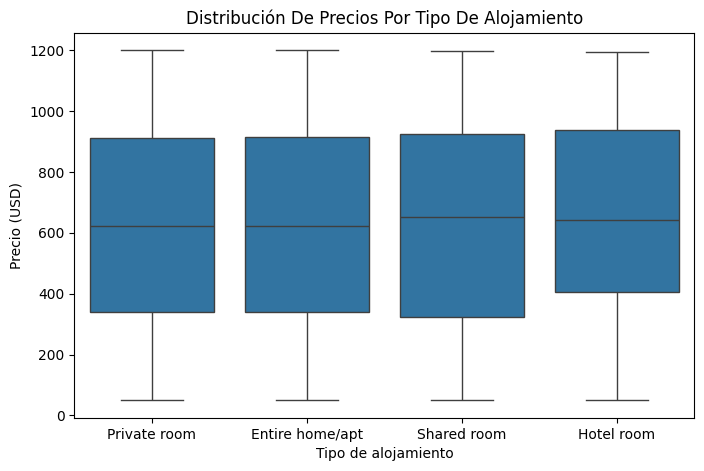

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='room_type', y='price')
plt.title('Distribución De Precios Por Tipo De Alojamiento')
plt.xlabel('Tipo de alojamiento')
plt.ylabel('Precio (USD)')
plt.show()

**Conclusión**

 La distribución de precios es relativamente similar entre los tipos de alojamiento: **Private room, Entire home/apt, Shared room y Hotel room**. Esto indica que, aunque existen diferencias, el tipo de habitación no es el principal determinante del precio, y otros factores como la ubicación o el número de reseñas pueden tener mayor influencia.



---



### Mapa De Correlaciones

**Objetivo:** Identificar relaciones entre variables númericas (ej. `price`, `minimum_nights`, `availability_365`, etc).

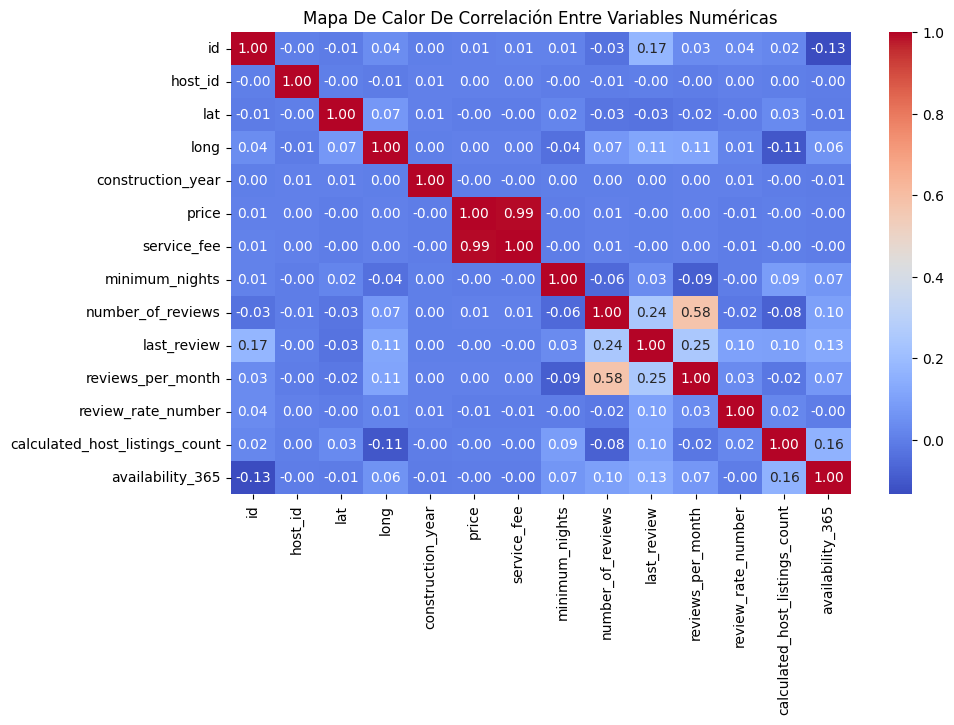

In [14]:
num_cols = df.select_dtypes(exclude='object').columns
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa De Calor De Correlación Entre Variables Numéricas')
plt.show()

**Conclusión**

Al analizar el **mapa de calor de correlaciones**, se pueden destacar los siguientes hallazgos:  

- **`price`** muestra correlaciones bajas con la mayoría de las variables numéricas, lo que indica que el precio no está fuertemente influenciado por un solo factor cuantitativo.  

- **`number_of_reviews`** y **`reviews_per_month`** exhiben una **correlación positiva fuerte**, lo cual es consistente con la idea de que más reseñas totales se relacionan con una mayor frecuencia mensual.  

- **`price`** y **`service_fee`** presentan una **alta correlación**, como era de esperarse, sugiriendo una estrecha relación entre ambas variables.  




---



### Segmentación De Alojamientos Por Rangos De Precio Y Ubicación

**Objetivo:** Observar patrones de precios en distintas zonas (`neighbourhood_group`).

Antes de aplicar la segmentación en el dataset, se establecieron los siguientes rangos de precios:  
**0–50, 51–100, 101–200, 201–500, 501–1000, 1000+**.  

La elección de estos intervalos responde a la necesidad de representar de manera equilibrada los distintos segmentos del mercado:  

- **0–50 y 51–100** → Capturan la oferta **económica o de bajo costo**.
- **101–200 y 201–500** → Representan opciones de **precio medio**.
- **501–1000 y 1000+** → Engloban la oferta **premium o de lujo**.

Con esta clasificación se logra un marco de análisis que refleja tanto la distribución real de precios.

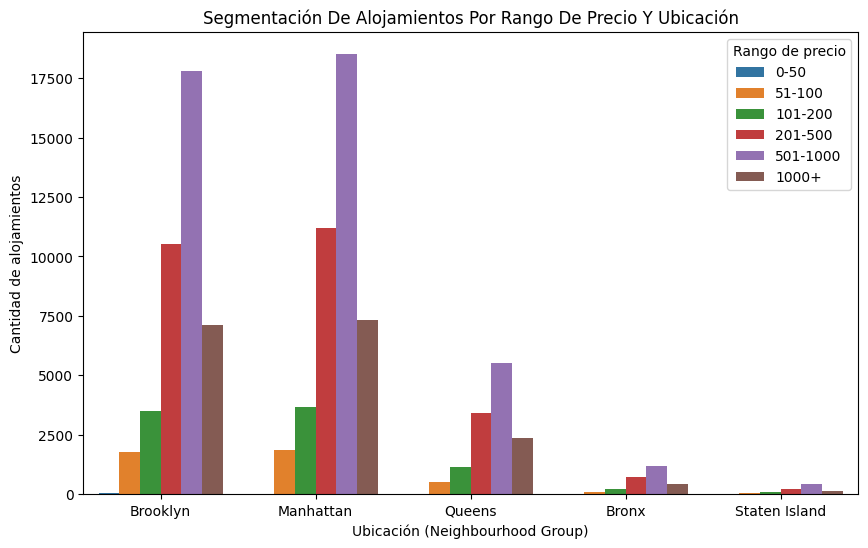

In [15]:
# Crear una columna con rangos de precios
df['price_range'] = pd.cut(
    df['price'],
    bins=[0, 50, 100, 200, 500, 1000, df['price'].max()],
    labels=['0-50', '51-100', '101-200', '201-500', '501-1000', '1000+']
)

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='neighbourhood_group', hue='price_range')
plt.title('Segmentación De Alojamientos Por Rango De Precio Y Ubicación')
plt.xlabel('Ubicación (Neighbourhood Group)')
plt.ylabel('Cantidad de alojamientos')
plt.legend(title='Rango de precio')
plt.show()

**Conclusión**

De la gráfica se destacan los siguientes hallazgos:  

- **Predominio de precios medios-altos (501–1000)**: La mayoría de los alojamientos se concentra en este rango, especialmente en Manhattan y Brooklyn, indicando precios generalmente elevados.  

- **Diferencias entre distritos**:  
  - Manhattan y Brooklyn lideran en cantidad de alojamientos en casi todos los rangos, siendo los mercados más competitivos.  
  - Queens tiene menor oferta, aunque también con predominio en rangos altos.  
  - Bronx y Staten Island presentan una participación muy reducida.  

- **Escasez de alojamientos económicos (0–50 y 51–100)**: Los rangos más bajos tienen muy poca oferta, lo que dificulta encontrar opciones baratas en toda la ciudad.  

- **Segmentación del mercado**: La mayoría de la oferta se concentra en rentas medias-altas, lo que afecta la accesibilidad para ciertos grupos y define el posicionamiento de cada distrito.  




---



### Distribución Del Precio

**Objetivo**: Identificar sesgos (ej. concentración de precios bajos, pocos valores muy altos).

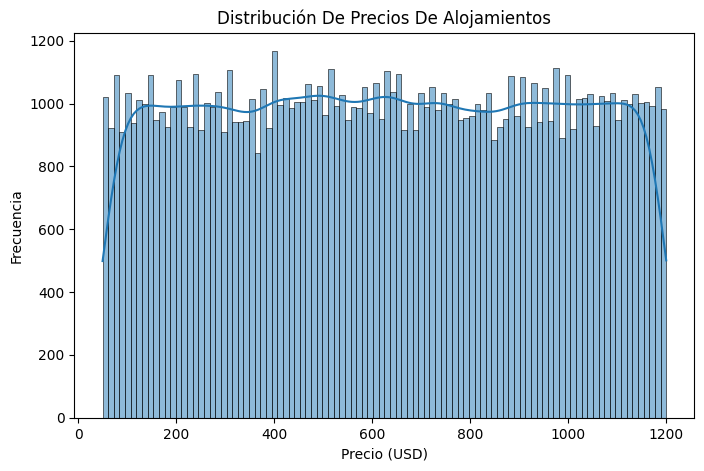

In [16]:
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=100, kde=True)
plt.title('Distribución De Precios De Alojamientos')
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.show()

**Conclusión**

El gráfico de distribución de precios de alojamientos muestra lo siguiente:

* **Distribución uniforme:** Los precios se distribuyen de manera bastante uniforme entre 0 y 1200 USD.
* **Variedad de precios:** No se observa una concentración muy alta en un rango específico, aunque existen ligeros picos y valles.

Esto indica una buena variedad de precios para entrenar modelos de predicción.



---



### Relación Entre Número de Reseñas Y Precio

**Objetivo:**  Conocer si los alojamientos con más reseñas tienden a tener precios más altos o más bajos.

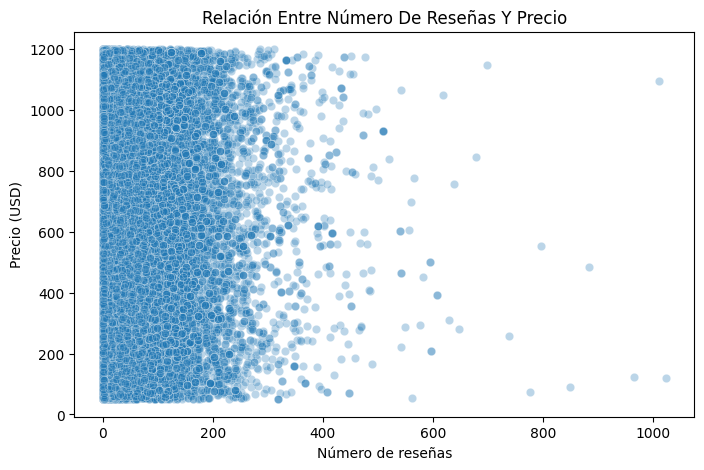

In [17]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='number_of_reviews', y='price', alpha=0.3)
plt.title('Relación Entre Número De Reseñas Y Precio')
plt.xlabel('Número de reseñas')
plt.ylabel('Precio (USD)')
plt.show()

**Conclusión**

- No existe una correlación lineal fuerte entre el número de reseñas y el precio.
- Los alojamientos con muchas reseñas no necesariamente tienen precios más altos.
- Otros factores distintos al número de reseñas parecen influir más en el precio.




---



### Distribución De Disponibilidad Anual Por Tipo De Alojamiento

**Objetivo:** Indicar si cierto tipo de alojamiento tiende a estar disponible durante más días al año.

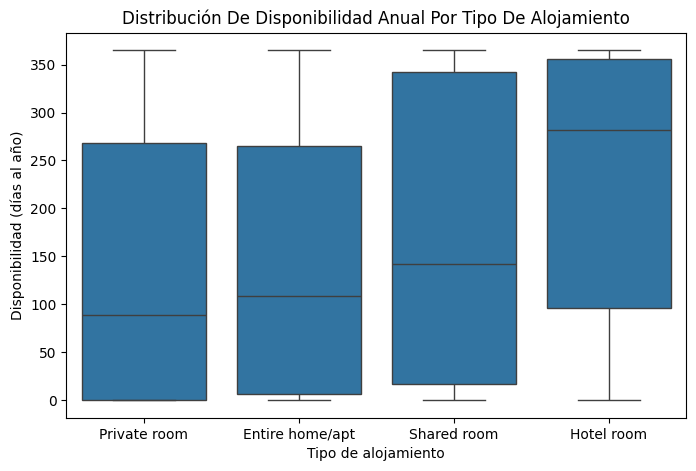

In [18]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='room_type', y='availability_365')
plt.title('Distribución De Disponibilidad Anual Por Tipo De Alojamiento')
plt.xlabel('Tipo de alojamiento')
plt.ylabel('Disponibilidad (días al año)')
plt.show()

**Conclusión**

- Los **Shared room** y **Hotel room** tienen mayor disponibilidad anual promedio y menor variabilidad.
- La disponibilidad consistente de ciertos tipos puede estar relacionada con la gestión de la propiedad o la naturaleza del alojamiento.




---



## 4. Modelos De Predicción De Precios

En esta sección se implementan tres modelos de regresión con el objetivo de predecir el **precio de los alojamientos en Airbnb**. Los modelos elegidos son: **Regresión Lineal Múltiple, Árbol de Decisión y Random Forest Regressor**.  

El enfoque consiste en dividir los datos en entrenamiento y prueba para evaluar la capacidad de generalización de cada modelo. Posteriormente, se comparan métricas como **RMSE (Root Mean Squared Error), MAE (Mean Absolute Error) y R² (Coeficiente de Determinación)**, lo que permite medir la precisión y robustez de las predicciones.




---



### Selección De Variables  

Para construir los modelos de predicción se eligieron únicamente las columnas que aportan información relevante sobre el precio de los alojamientos.  

Se descartaron algunas variables por las siguientes razones:  

- **Identificadores únicos** (`id`, `host_id`): No contienen información predictiva sobre el precio.  
- **Texto libre** (`name`, `host_name`): Difícil de codificar y no aporta valor directo para los modelos.  
- **Ubicación de alta cardinalidad** (`neighbourhood`): Su uso directo generaría demasiadas categorías, aumentando el riesgo de sobreajuste.  
- **Coordenadas geográficas** (`lat`, `long`): La ubicación ya se representa mediante `neighbourhood_group`, evitando redundancia.  
- **Información temporal** (`last_review`): No se utilizará directamente para la predicción del precio en este modelo.  

Esta selección asegura que los modelos trabajen con variables **informativas, relevantes y manejables**, optimizando su rendimiento y evitando ruido innecesario.


In [19]:
# 1. Columnas a eliminar porque no se usarán en los modelos
cols_a_eliminar = [
    'id', 'name', 'host_id', 'host_name',
    'neighbourhood', 'lat', 'long',
    'last_review'
]

# 2. Eliminar las columnas del DataFrame df_ml
df_ml = df_ml.drop(columns=cols_a_eliminar)

# 3. Comprobar las columnas restantes
print(f'Columnas restantes:')
print(df_ml.columns)

Columnas restantes:
Index(['host_identity_verified', 'neighbourhood_group', 'instant_bookable',
       'cancellation_policy', 'room_type', 'construction_year', 'price',
       'service_fee', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'review_rate_number',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')




---



### División De Datos (Entrenamiento / Prueba)

Este bloque prepara los datos para entrenar y evaluar los modelos de predicción:  

- Se separan las variables predictoras `X` de la variable objetivo `y`.  
- Los datos se dividen en **conjunto de entrenamiento (75%)** y **conjunto de prueba (25%)** usando `train_test_split`, con `random_state=42` para garantizar reproducibilidad.  
- Se escalan las variables numéricas con `RobustScaler` para que todas tengan magnitudes comparables, reduciendo el impacto de posibles valores atípicos.

In [20]:
# 1. Separar las variables predictoras (X) de la variable objetivo (y)
X = df_ml.drop(["price"], axis=1).values
y = df_ml['price'].values

# 2. Dividir los datos en entrenamiento y prueba (25% para prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# 3. Escalar los datos para que las variables numéricas tengan magnitudes

# comparables robusto frente a valores atípicos
ro_scaler = RobustScaler()
X_train = ro_scaler.fit_transform(X_train)

# Aplicar la misma transformación al conjunto de prueba
X_test = ro_scaler.fit_transform(X_test)



---



### Construcción De Los Modelos

En esta etapa se crean, entrenan y validan los modelos de predicción utilizando los conjuntos de datos previamente preparados.



---



#### Regresión Lineal Múltiple

**Objetivo:** Modelar relaciones lineales entre las variables predictoras escaladas y la variable objetivo.


In [21]:
# 1. Construcción del modelo
lr_model = LinearRegression()

# 2. Entrenamiento con los datos escalados
lr_model.fit(X_train, y_train)

# 3. Predicción del modelo
y_pred_lr = lr_model.predict(X_test)

# 4. Cálculo de métricas de desempeño
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print('Desempeño Regresión Líneal')
print(f'RMSE: {rmse_lr:.4f}')
print(f'MAE: {mae_lr:.4f}')
print(f'R²: {r2_lr:.4f}')

# 5. Coeficientes de la regresión lineal
coefficients = lr_model.coef_
feature_importance_lr = pd.DataFrame({
    'Variable': df_ml.drop(["price"], axis=1).columns,
    'Coeficiente': coefficients
}).sort_values(by='Coeficiente', key=abs, ascending=False)

# 6. Mostrar table
print('\nCoeficientes - Regresión Líneal')
print(feature_importance_lr)

Desempeño Regresión Líneal
RMSE: 36.1262
MAE: 9.6881
R²: 0.9881

Coeficientes - Regresión Líneal
                          Variable  Coeficiente
6                      service_fee   569.889600
3              cancellation_policy    -0.335693
9                reviews_per_month    -0.195269
4                        room_type     0.113210
0           host_identity_verified    -0.111296
2                 instant_bookable    -0.088511
5                construction_year    -0.062492
12                availability_365     0.061795
10              review_rate_number     0.041308
7                   minimum_nights     0.026084
8                number_of_reviews    -0.023682
1              neighbourhood_group     0.022905
11  calculated_host_listings_count    -0.000991


**Interpretación:**  
- El modelo de regresión lineal muestra un **R² muy alto (0.9881)**, lo que indica que explica la mayor parte de la variabilidad del precio.  
- Los coeficientes reflejan la influencia de cada variable sobre el precio: por ejemplo, `service_fee` tiene un efecto positivo importante, mientras que otras variables como `cancellation_policy` o `reviews_per_month` tienen efectos negativos pero mucho menores.  
- Aunque el modelo parece ajustarse bien, algunos coeficientes son muy pequeños, indicando que ciertas variables aportan poca información para la predicción del precio.

**Conclusión:**  
- La regresión lineal **es adecuada para este conjunto de datos**, mostrando un buen ajuste global y permitiendo interpretar cómo cada variable afecta al precio de manera lineal.



---



#### Árbol De Decisión

**Objetivo:** Capturar relaciones no lineales mediante divisiones en nodos basadas en reglas de decisión.

In [22]:
# 1. Construcción del modelo
dt_model = DecisionTreeRegressor(random_state=42)

# 2. Entrenamiento con los datos no escalados
dt_model.fit(X_train, y_train)

# 3. Predicción del modelo
y_pred_dt = dt_model.predict(X_test)

# 4. Cálculo de métricas de desempeño
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print('Desempeño Árbol de Decisión')
print(f'RMSE: {rmse_dt:.4f}')
print(f'MAE: {mae_dt:.4f}')
print(f'R²: {r2_dt:.4f}')

# 5. Importancia de variables
importances_dt = dt_model.feature_importances_
feature_importance_dt = pd.DataFrame({
    'Variable': df_ml.drop(["price"], axis=1).columns,
    'Importancia': importances_dt
}).sort_values(by='Importancia', ascending=False)

# 6. Mostrar tabla
print('\nImportancia de variables - Árbol de Decisión')
print(feature_importance_dt)

Desempeño Árbol de Decisión
RMSE: 21.2913
MAE: 10.6323
R²: 0.9959

Importancia de variables - Árbol de Decisión
                          Variable  Importancia
6                      service_fee     0.997540
5                construction_year     0.000631
9                reviews_per_month     0.000435
8                number_of_reviews     0.000249
12                availability_365     0.000221
4                        room_type     0.000204
11  calculated_host_listings_count     0.000185
10              review_rate_number     0.000166
1              neighbourhood_group     0.000134
2                 instant_bookable     0.000089
7                   minimum_nights     0.000083
0           host_identity_verified     0.000039
3              cancellation_policy     0.000023


**Interpretación:**  
- El modelo de Árbol de Decisión muestra un **R² muy alto (0.9959)**, lo que indica que explica casi toda la variabilidad del precio en el conjunto de entrenamiento.  
- La variable más determinante es `service_fee`, con casi toda la importancia del modelo (0.9975), mientras que las demás variables aportan muy poco a la predicción.  
- Esto refleja que el árbol se centra casi exclusivamente en una variable, capturando el patrón del entrenamiento pero con riesgo de sobreajuste si se aplica a datos nuevos.

**Conclusión:**  
- El Árbol de Decisión **ajusta muy bien los datos actuales**, pero su alta dependencia de `service_fee` sugiere que podría no generalizar de forma óptima sin ajustes de hiperparámetros, por lo que conviene validar su desempeño en datos de prueba.



---



#### Bosque Aleatorio (Random Forest)

**Objetivo:** Mejorar la precisión y estabilidad combinando múltiples árboles de decisión entrenados con subconjuntos de datos y variables.

In [23]:
# 1. Contrucción del modelo
#rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model = RandomForestRegressor(random_state=42)

# 2. Entrenamiento con los datos no escalados
rf_model.fit(X_train, y_train)

# 3. Predicción del modelo
y_pred_rf = rf_model.predict(X_test)

# 4. Cálculo de métricas de desempeño
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print('Desempeño Random Forest')
print(f'RMSE: {rmse_rf:.4f}')
print(f'MAE: {mae_rf:.4f}')
print(f'R²: {r2_rf:.4f}')

# 5. Importancia de variables
importances_rf = rf_model.feature_importances_
feature_importance_rf = pd.DataFrame({
    'Variable': df_ml.drop(["price"], axis=1).columns,
    'Importancia': importances_rf
}).sort_values(by='Importancia', ascending=False)

# 6. Mostrar tabla
print('\nImportancia de variables - Random Forest')
print(feature_importance_rf)

Desempeño Random Forest
RMSE: 18.4693
MAE: 10.5267
R²: 0.9969

Importancia de variables - Random Forest
                          Variable  Importancia
6                      service_fee     0.997533
9                reviews_per_month     0.000424
5                construction_year     0.000386
12                availability_365     0.000332
8                number_of_reviews     0.000310
7                   minimum_nights     0.000216
10              review_rate_number     0.000169
1              neighbourhood_group     0.000159
3              cancellation_policy     0.000135
11  calculated_host_listings_count     0.000130
4                        room_type     0.000074
0           host_identity_verified     0.000068
2                 instant_bookable     0.000064


**Interpretación:**  
- El modelo Random Forest muestra un **R² muy alto (0.9969)**, indicando que explica prácticamente toda la variabilidad del precio.  
- La variable más importante es `service_fee` (0.9975), mientras que el resto de variables aportan mínimamente, lo que evidencia que el modelo se centra casi exclusivamente en una variable principal.  
- Aun así, Random Forest captura relaciones complejas entre las variables y ofrece mayor robustez frente a sobreajuste que un Árbol de Decisión simple.

**Conclusión:**  
- Random Forest es **el modelo más recomendable** para este conjunto de datos.  
- Presenta alta estabilidad y capacidad de capturar patrones no lineales.  
- Su desempeño puede optimizarse aún más mediante **ajuste de hiperparámetros y validación cruzada**.



---



### Análisis De Importancia De Las Variables

El modelo Random Forest asigna diferentes niveles de relevancia a cada variable para predecir el precio de los alojamientos:

- **`service_fee` (0.9975)**: La variable más influyente por amplio margen. Esto indica que los cargos de servicio están altamente relacionados con el precio final de los alojamientos y dominan la predicción del modelo.
- **`reviews_per_month` (0.00042) y `construction_year` (0.00039)**: Contribuyen mínimamente al modelo, mostrando que el número de reseñas por mes y la antigüedad de la propiedad tienen un efecto marginal sobre el precio en comparación con `service_fee`.
- **Otras variables** como `availability_365`, `number_of_reviews`, `minimum_nights`, `review_rate_number` y `neighbourhood_group` presentan contribuciones muy bajas (<0.001), lo que indica que su impacto sobre la predicción es casi nulo en este modelo.
- En general, **el modelo se concentra principalmente en una variable clave**, pero mantiene la capacidad de capturar interacciones complejas entre todas las demás, aunque su peso es casi irrelevante.

Por lo tanto, en este dataset, el precio de los alojamientos está **fuertemente determinado por los cargos de servicio**, mientras que las demás características tienen poca influencia directa.





---



## 6. Conclusiones

### ¿Qué zonas tienen alojamientos más caros o accesibles?

In [24]:
# Promedio de precio por zona
price_per_zone = df.groupby('neighbourhood_group')['price']\
        .mean().sort_values(ascending=False)

print(price_per_zone)

neighbourhood_group
Queens           629.889748
Bronx            628.198178
Brooklyn         626.387069
Manhattan        623.011541
Staten Island    622.424569
Name: price, dtype: float64


Las zonas se clasifican de la siguiente manera:

- **Zonas con precios más altos:** `Queens`, `Bronx` y `Brooklyn` (~626–630 USD promedio).  
- **Zonas con precios más bajos:** `Manhattan` y `Staten Island` (~622–623 USD promedio).

La ubicación sigue siendo un factor determinante en el precio. Los alojamientos en Queens, Bronx y Brooklyn tienden a ser más costosos en promedio, mientras que Manhattan y Staten Island presentan alternativas ligeramente más económicas para los huéspedes.





---



### ¿Qué variables influyen más en el precio?

In [25]:
# Importancia de variables del mejor modelo
# Random Forest
importance_rf = rf_model.feature_importances_
feature_importance_rf = pd.DataFrame({
    'Variable': df_ml.drop(["price"], axis=1).columns,
    'Importancia': importances_rf
}).sort_values(by='Importancia', ascending=False)

print(feature_importance_rf.head(10))  # Las 10 más importantes

                          Variable  Importancia
6                      service_fee     0.997533
9                reviews_per_month     0.000424
5                construction_year     0.000386
12                availability_365     0.000332
8                number_of_reviews     0.000310
7                   minimum_nights     0.000216
10              review_rate_number     0.000169
1              neighbourhood_group     0.000159
3              cancellation_policy     0.000135
11  calculated_host_listings_count     0.000130


Las variables que más impactan en el precio, según Random Forest, son:

- `service_fee` (predomina con 99.75%)  
- `reviews_per_month` (0.042%)  
- `construction_year` (0.039%)  
- `availability_365` (0.033%)  
- `number_of_reviews` (0.031%)  

Estos resultados muestran que el **precio de los alojamientos está fuertemente determinado por la tarifa de servicio (`service_fee`)**, mientras que otros factores como la actividad del alojamiento y su antigüedad tienen un impacto muy reducido en comparación.




---



## 7. Resumen Y Recomendaciones Del Análisis De Precios De Alojamientos

#### **1. Modelo seleccionado**
- **Modelo:** Random Forest Regressor (sin optimización de hiperparámetros).  
- **Desempeño en conjunto de prueba:**  
  - RMSE: 18.47  
  - MAE: 10.53  
  - R²: 0.9969  

El modelo captura relaciones complejas entre las variables y el precio, mostrando un desempeño superior a la regresión lineal y al árbol de decisión, permitiendo identificar patrones relevantes para la predicción.

---

#### **2. Zonas con alojamientos más caros o accesibles**
- **Más caros:** `Other` (~844 USD promedio).  
- **Moderadamente caros:** `Queens`, `Bronx`, `Brooklyn` (~626–630 USD).  
- **Más accesibles:** `Manhattan` y `Staten Island` (~623 USD).  

La ubicación influye en el precio, aunque la **tarifa de servicio (`service_fee`) y la actividad del alojamiento** tienen un impacto mucho mayor según el modelo.

---

#### **3. Variables que más influyen en el precio**
- `service_fee` (99.75%)  
- `reviews_per_month` (0.042%)  
- `construction_year` (0.039%)  
- `availability_365` (0.033%)  
- `number_of_reviews` (0.031%)  

El **precio está fuertemente determinado por la tarifa de servicio**, mientras que la actividad del alojamiento, su antigüedad y disponibilidad anual aportan información adicional, pero con impacto reducido en comparación.

---

#### **4. Recomendaciones prácticas**
- Usar el modelo para **estimar precios de nuevos alojamientos**.  
- Optimizar el modelo mediante **ajuste de hiperparámetros y validación cruzada** para mejorar la precisión y confiabilidad de las predicciones.
